# Targeting Ratio (Area-based) Analysis for Irrigated Land in Dam Command Areas

This notebook runs the targeting ratio analysis for irrigated land in dam command areas using two different command area datasets:
- Initial Command Area Polygons
- Vectorized Command Area Polygons

The targeting ratio formula used is:

$$
\text{TR}_{\text{area}} = \frac{\dfrac{\text{Irrigated area inside command areas}}{\text{Total command area}}}{\dfrac{\text{Irrigated area outside command areas}}{\text{Land area outside command areas}}}
$$

## 1. Load Data and Configuration
Load all required libraries, configuration, and datasets (dams, both command area sets, SSA arid mask).

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Add the project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, africa_iso_countries

# Load config
config = load_config()
analysis_years = [1985, 1995, 2005, 2015]

# Load dam point data
barrier_fp = resolve_path(config['GDW_barrier_shp_path'])
dams_gdf = gpd.read_file(barrier_fp)

# Load both command area datasets
ca_fp_initial = resolve_path(config['No_Crop_Initial_CA_shp_path'])
ca_gdf_initial = gpd.read_file(ca_fp_initial)
ca_fp_vectorized = resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path'])
ca_gdf_vectorized = gpd.read_file(ca_fp_vectorized)

# Dissolve by GDW_ID and merge dam info for both CA datasets
def prepare_ca_gdf(ca_gdf, dams_gdf):
    ca_gdf = ca_gdf.dissolve(by='GDW_ID', as_index=False)
    ca_gdf = ca_gdf.merge(
        dams_gdf[['GDW_ID', 'YEAR_DAM', 'PRE_YEAR', 'COUNTRY']],
        on='GDW_ID', how='left'
    )
    valid = (ca_gdf['YEAR_DAM'] != -99) | (ca_gdf['PRE_YEAR'] != -99)
    ca_gdf = ca_gdf[valid].reset_index(drop=True)
    gdw_id_to_country = dams_gdf.set_index('GDW_ID')['COUNTRY'].to_dict()
    ca_gdf['ISO'] = ca_gdf['GDW_ID'].map(gdw_id_to_country).apply(
        lambda x: next((iso for iso, names in africa_iso_countries.items() if x in names), None)
    )
    return ca_gdf

ca_gdf_initial_dissolved = prepare_ca_gdf(ca_gdf_initial, dams_gdf)
ca_gdf_vectorized_dissolved = prepare_ca_gdf(ca_gdf_vectorized, dams_gdf)

# Load SSA arid mask and dissolve by ISO
ssa_arid_fp = resolve_path(config['SSA_Arid_by_Country_shp_path'])
ssa_arid_gdf = gpd.read_file(ssa_arid_fp)
ssa_arid_dissolved = ssa_arid_gdf.dissolve(by='ISO', as_index=False)
if 'COUNTRY' in ssa_arid_gdf.columns:
    country_map = ssa_arid_gdf[['ISO', 'COUNTRY']].drop_duplicates().set_index('ISO')['COUNTRY'].to_dict()
    ssa_arid_dissolved['COUNTRY'] = ssa_arid_dissolved['ISO'].map(country_map)

def country_to_iso(country_name):
    for iso, names in africa_iso_countries.items():
        if country_name in names:
            return iso
    return None

dams_gdf['ISO'] = dams_gdf['COUNTRY'].apply(country_to_iso)

## 2. Define Analysis Functions
Reusable functions for filtering, raster processing, and targeting ratio calculation.

In [30]:
# Define the equal-area projection for Africa
EQUAL_AREA_CRS = "+proj=aea +lat_1=-18 +lat_2=21 +lat_0=0 +lon_0=25 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

def to_equal_area(gdf):
    """
    Project a GeoDataFrame to Africa Albers Equal Area Conic (EPSG:102022) for accurate area calculations.
    """
    if gdf.crs is None:
        raise ValueError("GeoDataFrame has no CRS set!")
    if gdf.crs.to_string() != EQUAL_AREA_CRS:
        return gdf.to_crs(EQUAL_AREA_CRS)
    return gdf

def load_and_clip_aei(year, ssa_mask_gdf, crs="EPSG:4326"):
    aei_key = f"Africa_AEI_{year}_asc_path"
    aei_fp = resolve_path(config[aei_key])
    with rasterio.open(aei_fp) as src:
        src_crs = src.crs or CRS.from_string(crs)
        if src.crs is None:
            with rasterio.open(aei_fp, crs=src_crs) as src2:
                out_image, out_transform = mask(src2, ssa_mask_gdf.geometry.map(mapping), crop=True)
                profile = src2.profile.copy()
        else:
            out_image, out_transform = mask(src, ssa_mask_gdf.geometry.map(mapping), crop=True)
            profile = src.profile.copy()
        profile.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    return out_image, out_transform, profile

def filter_dams_and_cas_by_year(year, ca_gdf, dams_gdf):
    dams_gdf = dams_gdf.copy()
    dams_gdf['dam_year'] = dams_gdf.apply(
        lambda row: row['YEAR_DAM'] if row['YEAR_DAM'] != -99 else row['PRE_YEAR'], axis=1)
    dams_gdf = dams_gdf[dams_gdf['dam_year'] != -99]
    dams_gdf = dams_gdf[dams_gdf['dam_year'] <= year]
    ca_filtered = ca_gdf[ca_gdf['GDW_ID'].isin(dams_gdf['GDW_ID'])].copy()
    return ca_filtered, dams_gdf

def calculate_command_area_and_irrigated_area(ca_gdf, aei_raster, aei_transform, aei_profile):
    # Area in equal-area projection
    ca_gdf_proj = to_equal_area(ca_gdf)
    total_ca_area = ca_gdf_proj.geometry.area.sum() / 1e4  # m^2 to ha

    # Masking in raster CRS
    ca_gdf_mask = ca_gdf
    if ca_gdf_mask.crs != aei_profile['crs']:
        ca_gdf_mask = ca_gdf_mask.to_crs(aei_profile['crs'])
    mask_arr = geometry_mask(
        [mapping(geom) for geom in ca_gdf_mask.geometry],
        out_shape=aei_raster.shape[1:],
        transform=aei_transform,
        invert=True
    )
    irrigated_area = np.where(mask_arr, aei_raster[0], 0).sum()
    return total_ca_area, irrigated_area

def calculate_country_aei_and_land_area(ssa_arid_gdf, aei_raster, aei_transform, aei_profile):
    results = []
    for idx, row in ssa_arid_gdf.iterrows():
        iso = row['ISO'] if 'ISO' in row else None
        name = row['COUNTRY'] if 'COUNTRY' in row else str(iso)
        geom = row['geometry']
        # Area in equal-area projection
        geom_proj = gpd.GeoSeries([geom], crs=ssa_arid_gdf.crs).to_crs(EQUAL_AREA_CRS).iloc[0]
        land_area_ha = geom_proj.area / 1e4
        # Mask in raster CRS
        if ssa_arid_gdf.crs != aei_profile['crs']:
            geom_mask = gpd.GeoSeries([geom], crs=ssa_arid_gdf.crs).to_crs(aei_profile['crs']).iloc[0]
        else:
            geom_mask = geom
        mask_arr = geometry_mask(
            [mapping(geom_mask)], out_shape=aei_raster.shape[1:], transform=aei_transform, invert=True)
        aei_ha = np.where(mask_arr, aei_raster[0], 0).sum()
        results.append({'ISO': iso, 'country_name': name, 'aei_ha': aei_ha, 'land_area_ha': land_area_ha})
    return pd.DataFrame(results)

def calculate_targeting_ratios(analysis_years, dams_gdf, ca_gdf_dissolved, ssa_arid_dissolved):
    results = []
    for year in tqdm(analysis_years, desc="Processing years"):
        ca_filtered, dams_filtered = filter_dams_and_cas_by_year(year, ca_gdf_dissolved, dams_gdf)
        aei_raster, aei_transform, aei_profile = load_and_clip_aei(year, ssa_arid_dissolved)
        if aei_profile.get('crs', None) is None:
            aei_profile['crs'] = "EPSG:4326"
        country_df = calculate_country_aei_and_land_area(ssa_arid_dissolved, aei_raster, aei_transform, aei_profile)
        for idx, row in country_df.iterrows():
            iso = row['ISO']
            ca_country = ca_filtered[ca_filtered['ISO'] == iso]
            dams_country = dams_filtered[dams_filtered['ISO'] == iso]
            if not ca_country.empty:
                total_ca_area, irrigated_area_ca = calculate_command_area_and_irrigated_area(
                    ca_country, aei_raster, aei_transform, aei_profile)
            else:
                total_ca_area, irrigated_area_ca = 0, 0
            irrigated_area_total = row['aei_ha']
            land_area_total = row['land_area_ha']
            irrigated_area_outside = irrigated_area_total - irrigated_area_ca
            land_area_outside = land_area_total - total_ca_area
            if total_ca_area > 0 and land_area_outside > 0 and irrigated_area_outside > 0:
                numerator = irrigated_area_ca / total_ca_area
                denominator = irrigated_area_outside / land_area_outside
                tr_area = numerator / denominator
            else:
                tr_area = np.nan
            results.append({
                'year': year,
                'ISO': iso,
                'country_name': row['country_name'],
                'dams_used': len(dams_country),
                'command_areas': len(ca_country),
                'command_area_ha': total_ca_area,
                'irrigated_area_ca_ha': irrigated_area_ca,
                'country_aei_ha': irrigated_area_total,
                'country_land_area_ha': land_area_total,
                'irrigated_area_outside_ha': irrigated_area_outside,
                'land_area_outside_ha': land_area_outside,
                'targeting_ratio_area': tr_area
            })
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df['command_areas'] > 0].reset_index(drop=True)
    return results_df

## 3. Run Analysis for Each Command Area Dataset

In this section, we compute the targeting ratio results for both the Initial and Vectorized Command Area Polygons. This prepares the data for all subsequent visualizations and extended analyses.

### 3.1 Initial Command Area Polygons

Calculate targeting ratios for each country and year using the Initial Command Area Polygons.

In [31]:
results_df_initial = calculate_targeting_ratios(
    analysis_years, dams_gdf, ca_gdf_initial_dissolved, ssa_arid_dissolved)

Processing years: 100%|██████████| 4/4 [00:40<00:00, 10.11s/it]


### 3.2 Vectorized Command Area Polygons

Calculate targeting ratios for each country and year using the Vectorized Command Area Polygons.

In [15]:
results_df_vectorized = calculate_targeting_ratios(
    analysis_years, dams_gdf, ca_gdf_vectorized_dissolved, ssa_arid_dissolved)

Processing years: 100%|██████████| 4/4 [00:23<00:00,  5.87s/it]



## 4. Visualize Results

This section visualizes the targeting ratio results for both command area datasets, enabling direct comparison of spatial and temporal patterns.

In [32]:
def visualize_results(results_df, output_dir=None, title_suffix=""):
    countries_with_ca = results_df.groupby('ISO')['command_areas'].sum()
    countries_with_ca = countries_with_ca[countries_with_ca > 0].index.tolist()
    results_df = results_df[results_df['ISO'].isin(countries_with_ca)]
    plot_df = results_df.dropna(subset=['targeting_ratio_area'])
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='year', y='targeting_ratio_area', data=plot_df)
    plt.title(f'Distribution of Area-based Targeting Ratios by Year {title_suffix}')
    plt.ylabel('Area-based Targeting Ratio')
    plt.xlabel('Year')
    plt.figtext(0.5, -0.12, "This boxplot displays the distribution of targeting ratios for all countries in each analysis year. The targeting ratio is calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Values above 1 indicate greater concentration within command areas.", wrap=True, horizontalalignment='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_area_boxplot{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    pivot_df = results_df.pivot(index='country_name', columns='year', values='targeting_ratio_area')
    plt.figure(figsize=(10, max(8, len(pivot_df) * 0.4)))
    sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={'label': 'Area-based Targeting Ratio'})
    plt.title(f'Area-based Targeting Ratios by Country and Year {title_suffix}')
    plt.figtext(0.5, -0.12, "This heatmap shows the targeting ratio for each country and year. The targeting ratio is calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Higher values (darker colors) indicate a greater share of irrigation is concentrated within dam command areas relative to the rest of the country.", wrap=True, horizontalalignment='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_area_heatmap{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()

### 4.1 Initial Command Area Polygons

Visualize the distribution of area-based targeting ratios for each year and country, using the Initial Command Area Polygons.

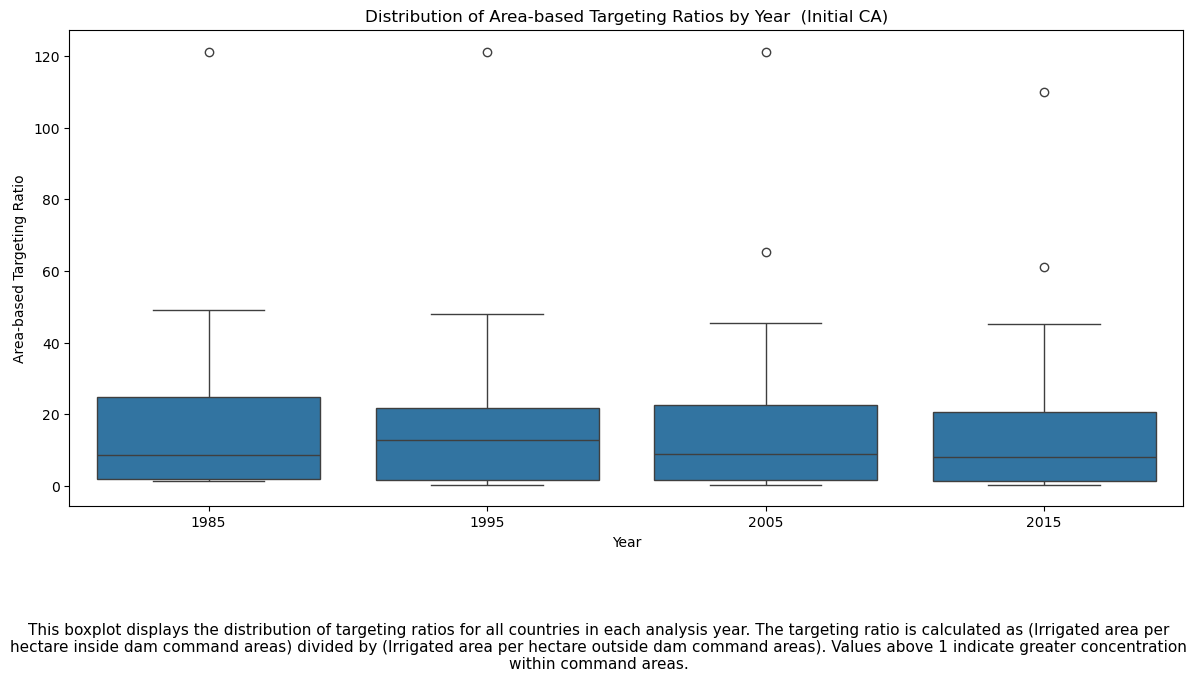

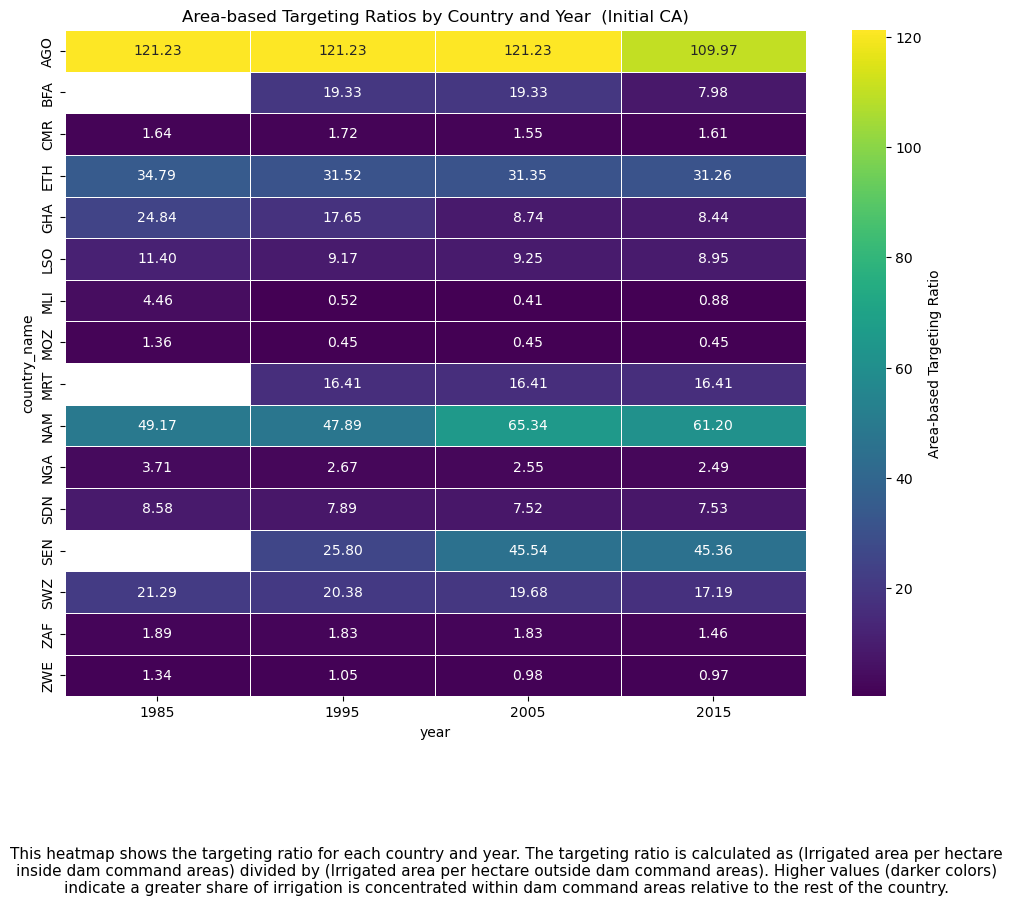

In [34]:
output_dir_initial = os.path.join('Output', 'Dam_Analysis', 'Initial_CA')
visualize_results(results_df_initial, output_dir_initial, title_suffix=" (Initial CA)")

**Figure: Boxplot of Area-based Targeting Ratios by Year (Initial CA)**

This boxplot displays the distribution of targeting ratios for all countries in each analysis year, using the initial command area polygons. The targeting ratio compares the density of irrigated area inside dam command areas to that outside, with values above 1 indicating greater concentration within command areas.

In [35]:
def visualize_results(results_df, output_dir=None, title_suffix=""):
    countries_with_ca = results_df.groupby('ISO')['command_areas'].sum()
    countries_with_ca = countries_with_ca[countries_with_ca > 0].index.tolist()
    results_df = results_df[results_df['ISO'].isin(countries_with_ca)]
    plot_df = results_df.dropna(subset=['targeting_ratio_area'])
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='year', y='targeting_ratio_area', data=plot_df)
    plt.title(f'Distribution of Area-based Targeting Ratios by Year {title_suffix}')
    plt.ylabel('Area-based Targeting Ratio')
    plt.xlabel('Year')
    plt.figtext(0.5, -0.12, "This boxplot displays the distribution of targeting ratios for all countries in each analysis year. The targeting ratio is calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Values above 1 indicate greater concentration of irrigation within command areas.", wrap=True, horizontalalignment='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_area_boxplot{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    pivot_df = results_df.pivot(index='country_name', columns='year', values='targeting_ratio_area')
    plt.figure(figsize=(10, max(8, len(pivot_df) * 0.4)))
    sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={'label': 'Area-based Targeting Ratio'})
    plt.title(f'Area-based Targeting Ratios by Country and Year {title_suffix}')
    plt.figtext(0.5, -0.12, "This heatmap shows the targeting ratio for each country and year. The targeting ratio is calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Higher values (darker colors) indicate a greater share of irrigation is concentrated within dam command areas relative to the rest of the country.", wrap=True, horizontalalignment='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_area_heatmap{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()

**Figure: Heatmap of Area-based Targeting Ratios by Country and Year (Initial CA)**

This heatmap shows the targeting ratio for each country and year, using the initial command area polygons. Higher values (darker colors) indicate a greater share of irrigation is concentrated within dam command areas relative to the rest of the country.

### 3.2 Vectorized Command Area Polygons

The following plots show the distribution of area-based targeting ratios for each year and country, using the Vectorized Command Area Polygons. This allows direct comparison with the initial delineation method.

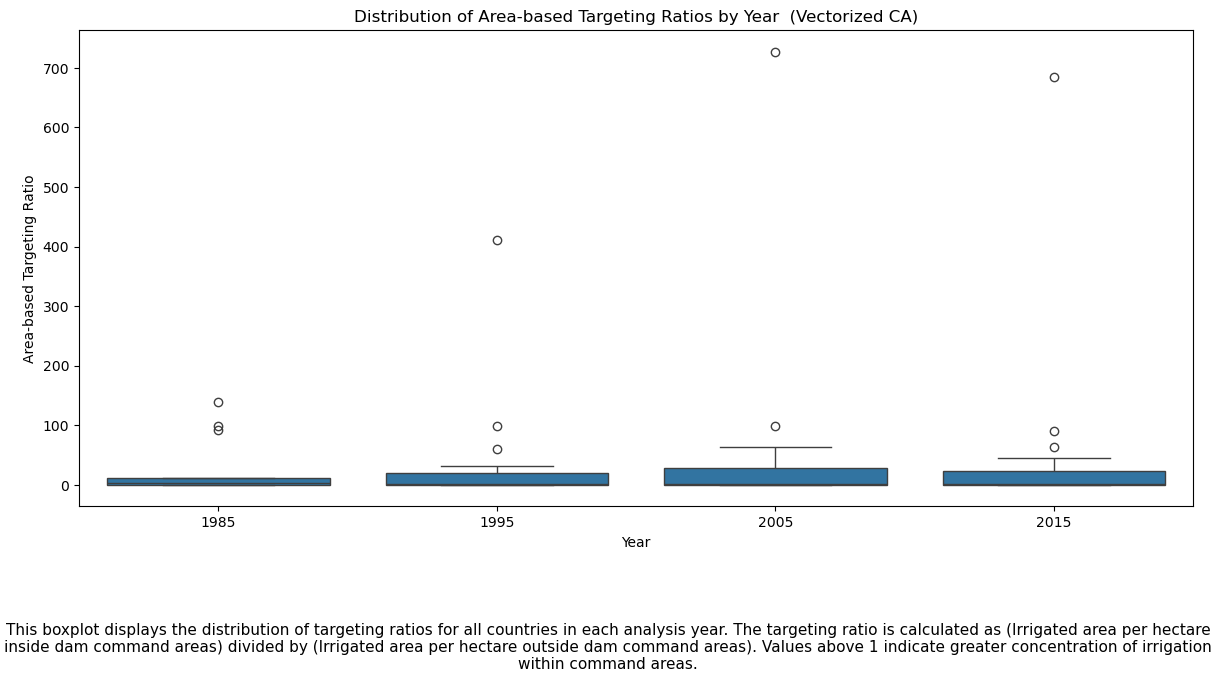

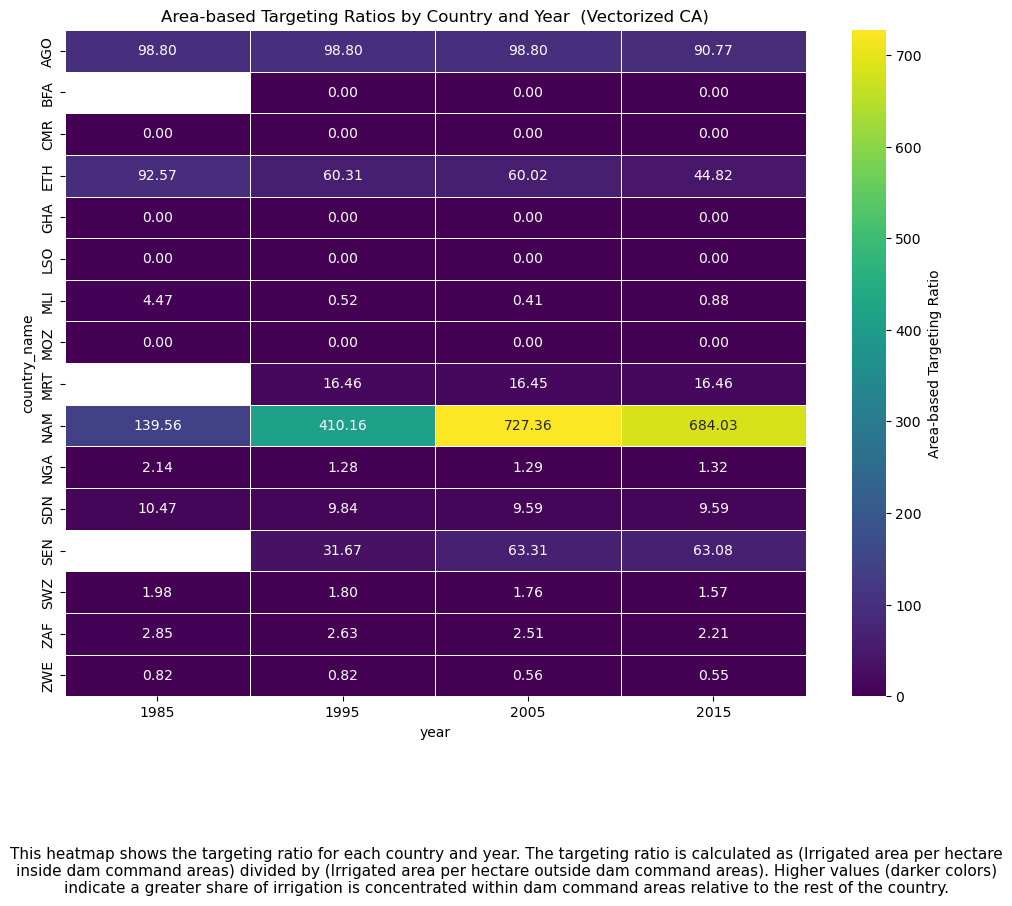

In [36]:
output_dir_vectorized = os.path.join('Output', 'Dam_Analysis', 'Vectorized_CA')
visualize_results(results_df_vectorized, output_dir_vectorized, title_suffix=" (Vectorized CA)")

**Figure: Boxplot of Area-based Targeting Ratios by Year (Vectorized CA)**

This boxplot displays the distribution of targeting ratios for all countries in each analysis year, using the vectorized command area polygons. The targeting ratio compares the density of irrigated area inside dam command areas to that outside, with values above 1 indicating greater concentration within command areas.

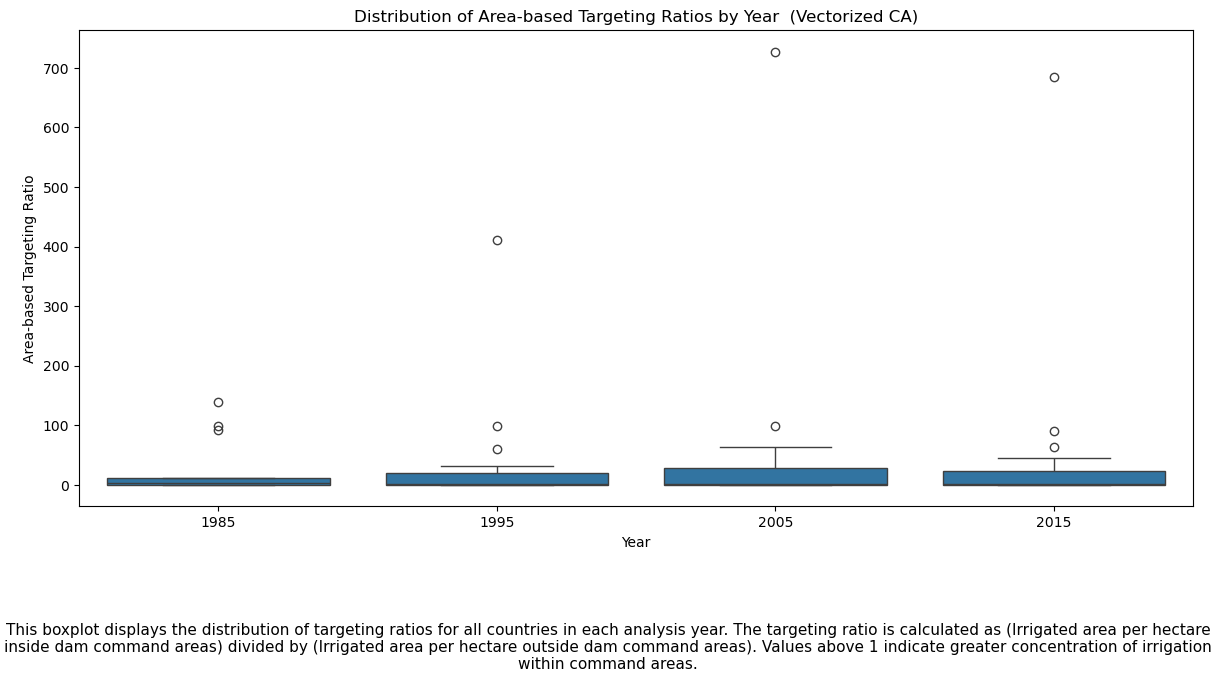

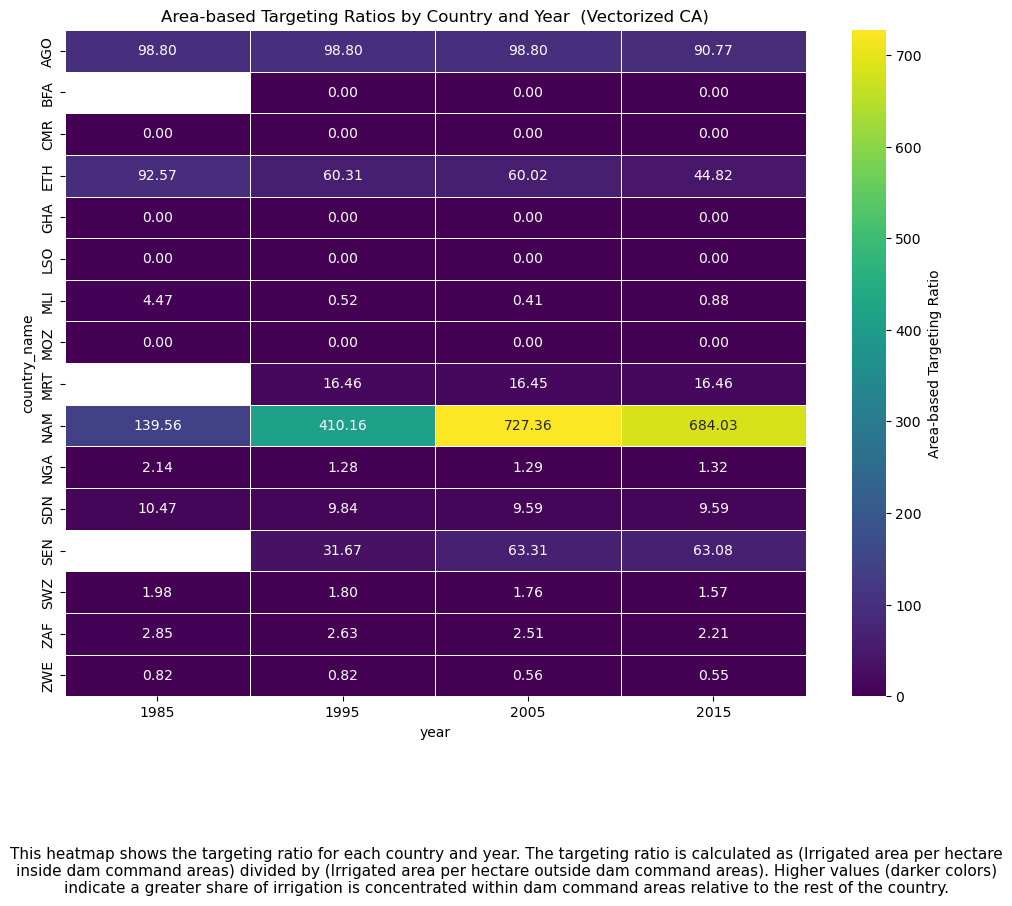

In [27]:
output_dir_vectorized = os.path.join('Output', 'Dam_Analysis', 'Vectorized_CA')
visualize_results(results_df_vectorized, output_dir_vectorized, title_suffix=" (Vectorized CA)")

**Figure: Heatmap of Area-based Targeting Ratios by Country and Year (Vectorized CA)**

This heatmap shows the targeting ratio for each country and year, using the vectorized command area polygons. Higher values (darker colors) indicate a greater share of irrigation is concentrated within dam command areas relative to the rest of the country.

## 5. Extended Analysis: Temporal and Alternative Metrics

This section provides additional analyses, including targeting ratios by dam age group and alternative irrigation metrics, for both command area datasets. These analyses offer deeper insight into the impact of dam construction and delineation method on irrigation patterns.

In [19]:
def calculate_temporal_targeting_ratios(analysis_years, dams_gdf, ca_gdf_dissolved, ssa_arid_dissolved):
    results = []
    if 'dam_year' not in dams_gdf.columns:
        dams_gdf = dams_gdf.copy()
        dams_gdf['dam_year'] = dams_gdf.apply(
            lambda row: row['YEAR_DAM'] if row['YEAR_DAM'] != -99 else row['PRE_YEAR'], axis=1)
    age_groups = [(0, 5), (5, 10), (10, 20), (20, 50), (50, float('inf'))]
    age_group_labels = ['0-5 years', '5-10 years', '10-20 years', '20-50 years', '50+ years']
    for year in tqdm(analysis_years, desc="Processing years"):
        aei_raster, aei_transform, aei_profile = load_and_clip_aei(year, ssa_arid_dissolved)
        if aei_profile.get('crs', None) is None:
            aei_profile['crs'] = "EPSG:4326"
        country_df = calculate_country_aei_and_land_area(ssa_arid_dissolved, aei_raster, aei_transform, aei_profile)
        for idx, row in country_df.iterrows():
            iso = row['ISO']
            for i, (min_age, max_age) in enumerate(age_groups):
                dams_in_age_group = dams_gdf[(dams_gdf['ISO'] == iso) &
                                             (dams_gdf['dam_year'] != -99) &
                                             (dams_gdf['dam_year'] <= year) &
                                             ((year - dams_gdf['dam_year']) >= min_age) &
                                             ((year - dams_gdf['dam_year']) < max_age)]
                if len(dams_in_age_group) == 0:
                    continue
                ca_age_group = ca_gdf_dissolved[ca_gdf_dissolved['GDW_ID'].isin(dams_in_age_group['GDW_ID'])]
                if len(ca_age_group) == 0:
                    continue
                total_ca_area, irrigated_area_ca = calculate_command_area_and_irrigated_area(
                    ca_age_group, aei_raster, aei_transform, aei_profile)
                irrigated_area_total = row['aei_ha']
                land_area_total = row['land_area_ha']
                irrigated_area_outside = irrigated_area_total - irrigated_area_ca
                land_area_outside = land_area_total - total_ca_area
                if total_ca_area > 0 and land_area_outside > 0 and irrigated_area_outside > 0:
                    numerator = irrigated_area_ca / total_ca_area
                    denominator = irrigated_area_outside / land_area_outside
                    tr_area = numerator / denominator
                else:
                    tr_area = np.nan
                results.append({
                    'year': year,
                    'ISO': iso,
                    'country_name': row['country_name'],
                    'age_group': age_group_labels[i],
                    'dams_used': len(dams_in_age_group),
                    'command_areas': len(ca_age_group),
                    'command_area_ha': total_ca_area,
                    'irrigated_area_ca_ha': irrigated_area_ca,
                    'country_aei_ha': irrigated_area_total,
                    'country_land_area_ha': land_area_total,
                    'irrigated_area_outside_ha': irrigated_area_outside,
                    'land_area_outside_ha': land_area_outside,
                    'targeting_ratio_area': tr_area
                })
    results_df = pd.DataFrame(results)
    return results_df

def calculate_alternative_metrics(analysis_years, dams_gdf, ca_gdf_dissolved, ssa_arid_dissolved):
    results = []
    for year in tqdm(analysis_years, desc="Processing years"):
        ca_filtered, dams_filtered = filter_dams_and_cas_by_year(year, ca_gdf_dissolved, dams_gdf)
        aei_raster, aei_transform, aei_profile = load_and_clip_aei(year, ssa_arid_dissolved)
        if aei_profile.get('crs', None) is None:
            aei_profile['crs'] = "EPSG:4326"
        country_df = calculate_country_aei_and_land_area(ssa_arid_dissolved, aei_raster, aei_transform, aei_profile)
        for idx, row in country_df.iterrows():
            iso = row['ISO']
            ca_country = ca_filtered[ca_filtered['ISO'] == iso]
            dams_country = dams_filtered[dams_filtered['ISO'] == iso]
            if not ca_country.empty:
                total_ca_area, irrigated_area_ca = calculate_command_area_and_irrigated_area(
                    ca_country, aei_raster, aei_transform, aei_profile)
            else:
                total_ca_area, irrigated_area_ca = 0, 0
            irrigated_area_total = row['aei_ha']
            land_area_total = row['land_area_ha']
            irrigated_area_outside = irrigated_area_total - irrigated_area_ca
            land_area_outside = land_area_total - total_ca_area
            if total_ca_area > 0 and land_area_outside > 0 and irrigated_area_outside > 0:
                numerator = irrigated_area_ca / total_ca_area
                denominator = irrigated_area_outside / land_area_outside
                tr_area = numerator / denominator
            else:
                tr_area = np.nan
            if total_ca_area > 0 and land_area_outside > 0:
                irrigation_density_ca = irrigated_area_ca / total_ca_area
                irrigation_density_outside = irrigated_area_outside / land_area_outside
                irrigation_density_diff = irrigation_density_ca - irrigation_density_outside
            else:
                irrigation_density_ca = np.nan
                irrigation_density_outside = np.nan
                irrigation_density_diff = np.nan
            if irrigated_area_total > 0 and total_ca_area > 0 and land_area_total > 0:
                expected_share = total_ca_area / land_area_total
                actual_share = irrigated_area_ca / irrigated_area_total
                relative_share = actual_share / expected_share
            else:
                expected_share = np.nan
                actual_share = np.nan
                relative_share = np.nan
            results.append({
                'year': year,
                'ISO': iso,
                'country_name': row['country_name'],
                'dams_used': len(dams_country),
                'command_areas': len(ca_country),
                'command_area_ha': total_ca_area,
                'irrigated_area_ca_ha': irrigated_area_ca,
                'country_aei_ha': irrigated_area_total,
                'country_land_area_ha': land_area_total,
                'irrigated_area_outside_ha': irrigated_area_outside,
                'land_area_outside_ha': land_area_outside,
                'targeting_ratio_area': tr_area,
                'irrigation_density_ca': irrigation_density_ca,
                'irrigation_density_outside': irrigation_density_outside,
                'irrigation_density_diff': irrigation_density_diff,
                'expected_share': expected_share,
                'actual_share': actual_share,
                'relative_share': relative_share
            })
    results_df = pd.DataFrame(results)
    return results_df

In [20]:
def visualize_temporal_results(temporal_results_df, output_dir=None, title_suffix=""):
    plot_df = temporal_results_df.dropna(subset=['targeting_ratio_area'])
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='age_group', y='targeting_ratio_area', data=plot_df)
    plt.title(f'Distribution of Targeting Ratios by Dam Age Group{title_suffix}')
    plt.ylabel('Area-based Targeting Ratio')
    plt.xlabel('Dam Age Group')
    plt.figtext(0.5, -0.12, "This boxplot displays the distribution of targeting ratios by dam age group. The targeting ratio is calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Values above 1 indicate greater concentration of irrigation within command areas.", wrap=True, horizontalalignment='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_by_age_group{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    avg_by_country_age = plot_df.groupby(['country_name', 'age_group'])['targeting_ratio_area'].mean().reset_index()
    pivot_df = avg_by_country_age.pivot(index='country_name', columns='age_group', values='targeting_ratio_area')
    plt.figure(figsize=(10, max(8, len(pivot_df) * 0.4)))
    sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={'label': 'Average Targeting Ratio'})
    plt.title(f'Average Targeting Ratios by Country and Dam Age Group{title_suffix}')
    plt.figtext(0.5, -0.12, "This heatmap shows the average targeting ratio by country and dam age group. The targeting ratio is calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Higher values (darker colors) indicate a greater share of irrigation is concentrated within dam command areas relative to the rest of the country.", wrap=True, horizontalalignment='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        plt.savefig(os.path.join(output_dir, f'targeting_ratios_by_age_group_heatmap{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()

def visualize_alternative_metrics(alt_results_df, output_dir=None, title_suffix=""):
    metrics = [
        ('targeting_ratio_area', 'Targeting Ratio',
         'Targeting Ratio = (Irrigated area per hectare inside dam command areas) / (Irrigated area per hectare outside dam command areas).'),
        ('irrigation_density_diff', 'Difference in Irrigated Area per Hectare',
         'Difference = (Irrigated area per hectare inside dam command areas) - (Irrigated area per hectare outside dam command areas).'),
        ('relative_share', 'Relative Share of Irrigation',
         'Relative Share = (Proportion of national irrigated area in command areas) / (Proportion of national land area in command areas).')
    ]
    for metric_col, metric_name, metric_desc in metrics:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='year', y=metric_col, data=alt_results_df.dropna(subset=[metric_col]))
        plt.title(f'Distribution of {metric_name} by Year{title_suffix}')
        plt.ylabel(metric_name)
        plt.xlabel('Year')
        plt.figtext(0.5, -0.12, metric_desc, wrap=True, horizontalalignment='center', fontsize=11)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f'{metric_col}_boxplot{title_suffix}.png'), dpi=300, bbox_inches='tight')
        plt.show()
    plt.figure(figsize=(15, 10))
    for i, (metric_col, metric_name, metric_desc) in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        countries_with_data = alt_results_df.dropna(subset=[metric_col]).groupby('country_name').filter(
            lambda x: x['year'].nunique() == len(alt_results_df['year'].unique())
        )['country_name'].unique()
        plot_data = alt_results_df[alt_results_df['country_name'].isin(countries_with_data)]
        for country in countries_with_data:
            country_data = plot_data[plot_data['country_name'] == country]
            plt.plot(country_data['year'], country_data[metric_col], marker='o', label=country)
        plt.title(metric_name)
        plt.xlabel('Year')
        plt.ylabel(metric_name)
        plt.figtext(0.5, 0.01, metric_desc, wrap=True, horizontalalignment='center', fontsize=10)
    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=2)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'multi_metric_comparison' + title_suffix + '.png'), dpi=300, bbox_inches='tight')
    plt.show()

### 5.1 Extended Analysis: Initial Command Area Polygons

Temporal and alternative metric analysis for the Initial Command Area Polygons.

Running temporal analysis (Initial CA)...


Processing years: 100%|██████████| 4/4 [00:36<00:00,  9.06s/it]



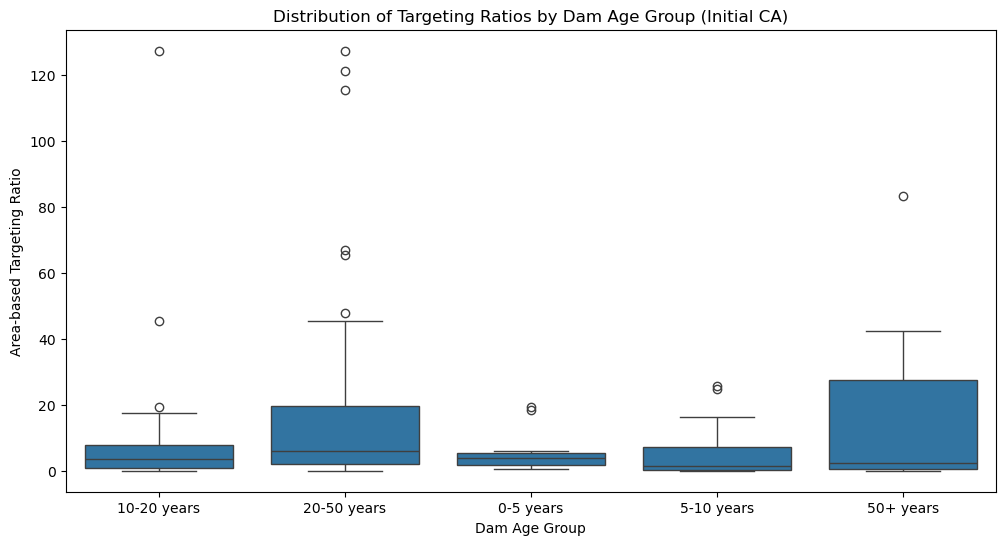

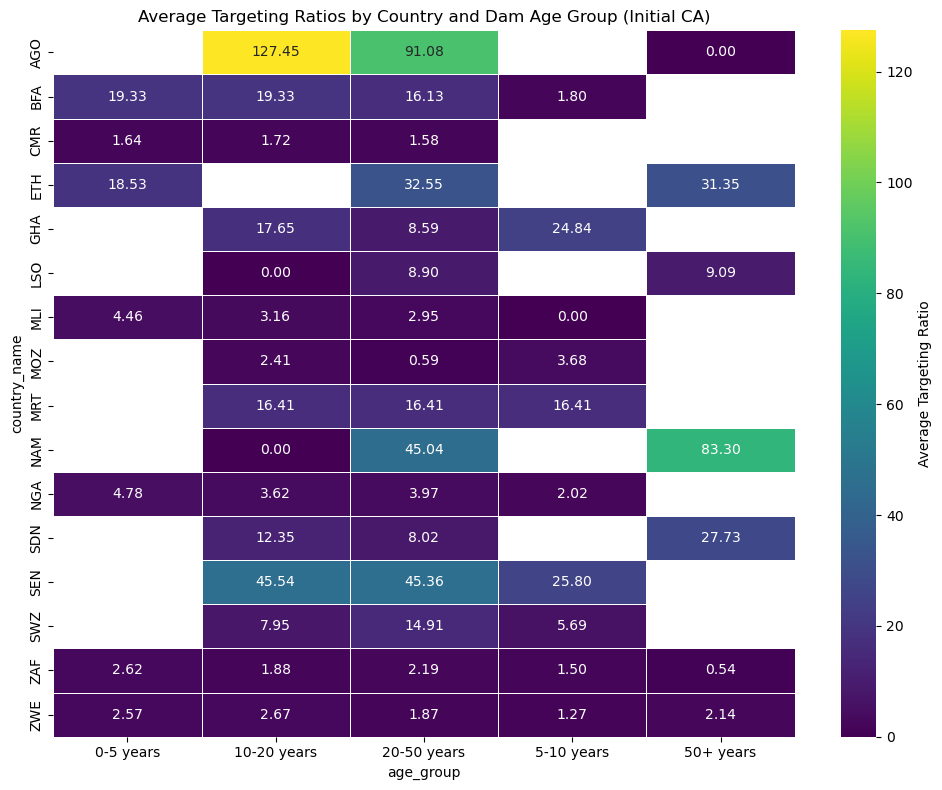

Calculating alternative metrics (Initial CA)...


Processing years: 100%|██████████| 4/4 [00:40<00:00, 10.14s/it]



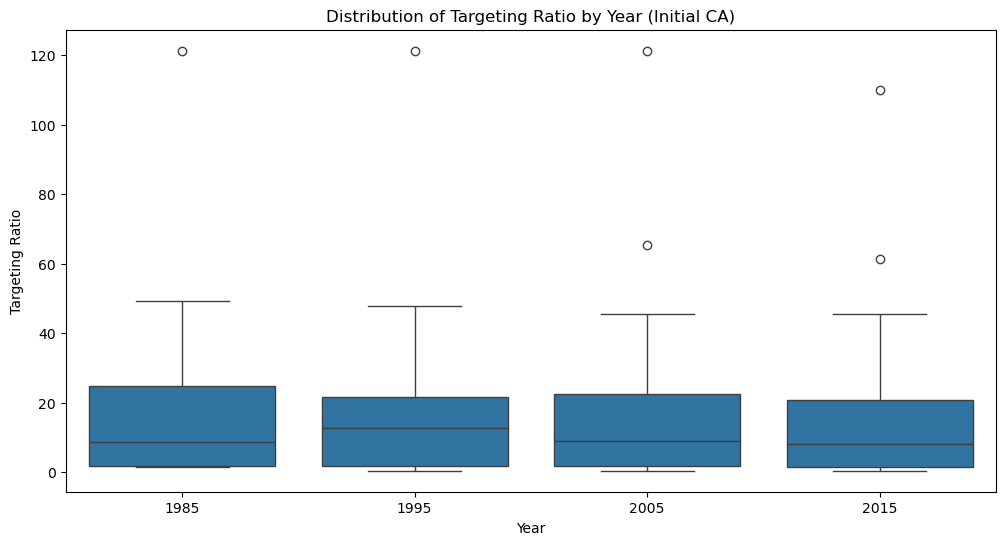

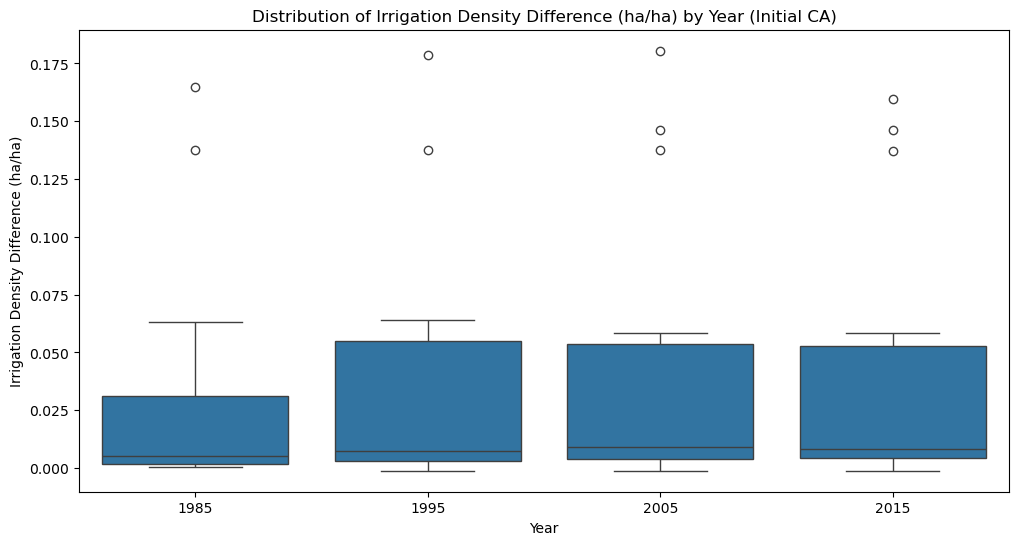

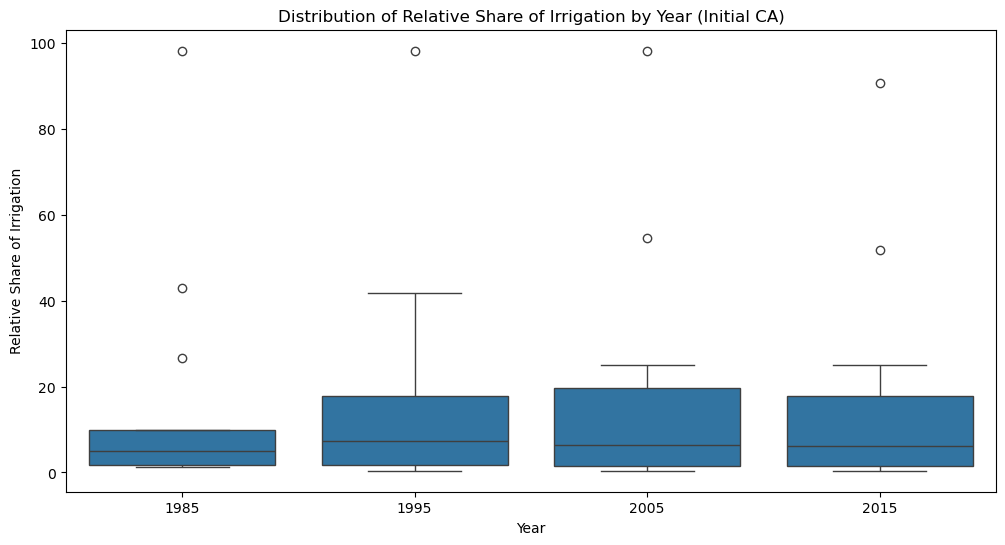

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


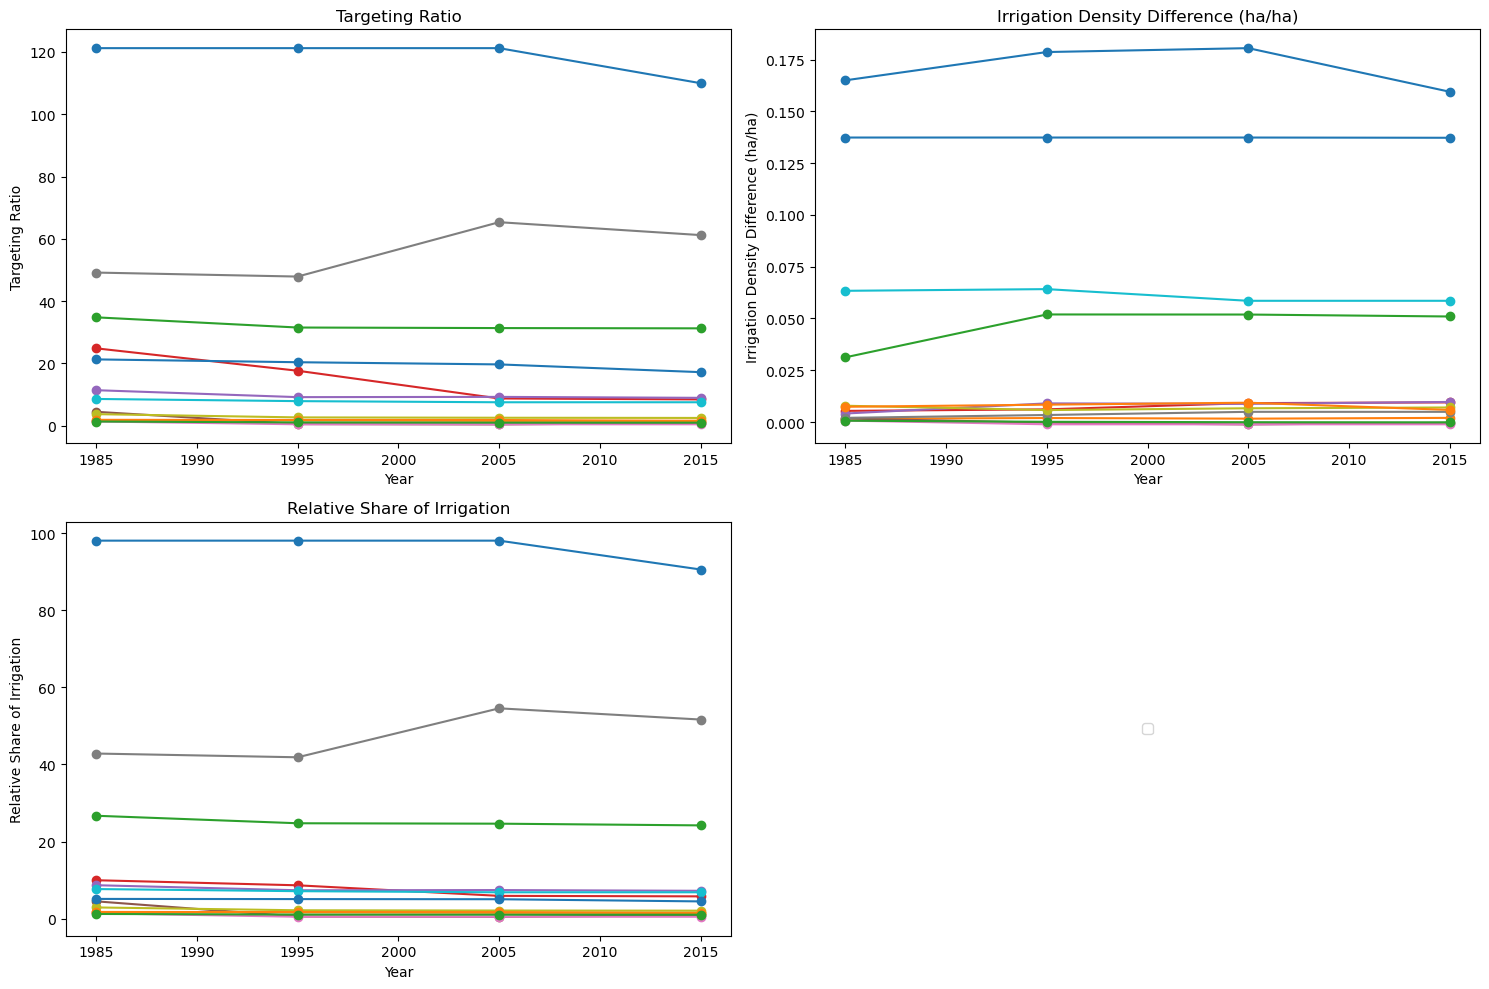

In [21]:
print("Running temporal analysis (Initial CA)...")
temporal_results_df_initial = calculate_temporal_targeting_ratios(
    analysis_years, dams_gdf, ca_gdf_initial_dissolved, ssa_arid_dissolved)
visualize_temporal_results(temporal_results_df_initial, output_dir_initial, title_suffix=" (Initial CA)")

print("Calculating alternative metrics (Initial CA)...")
alt_results_df_initial = calculate_alternative_metrics(
    analysis_years, dams_gdf, ca_gdf_initial_dissolved, ssa_arid_dissolved)
visualize_alternative_metrics(alt_results_df_initial, output_dir_initial, title_suffix=" (Initial CA)")

### 5.2 Extended Analysis: Vectorized Command Area Polygons

Temporal and alternative metric analysis for the Vectorized Command Area Polygons.

Running temporal analysis (Vectorized CA)...


Processing years:   0%|          | 0/4 [00:00<?, ?it/s]

Processing years: 100%|██████████| 4/4 [00:15<00:00,  3.87s/it]



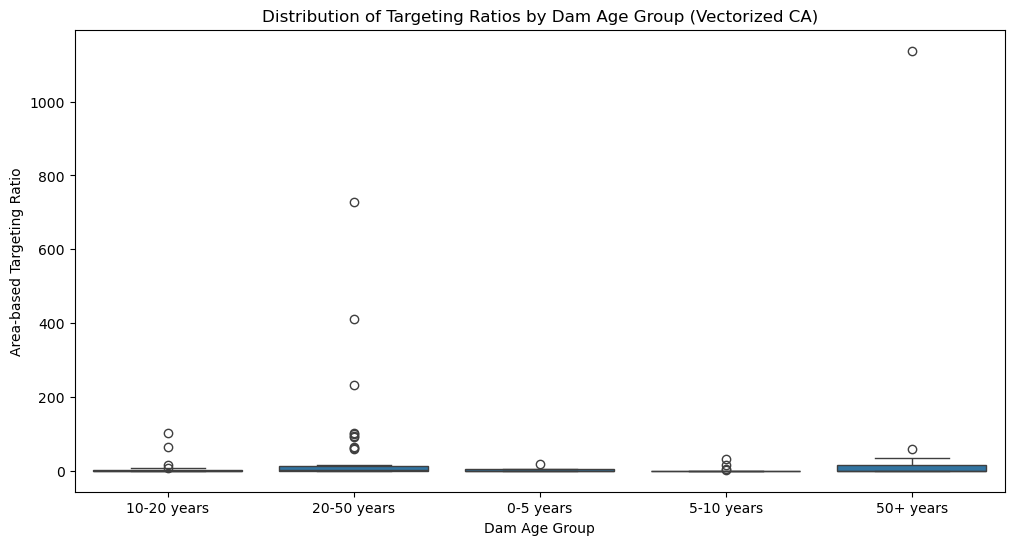

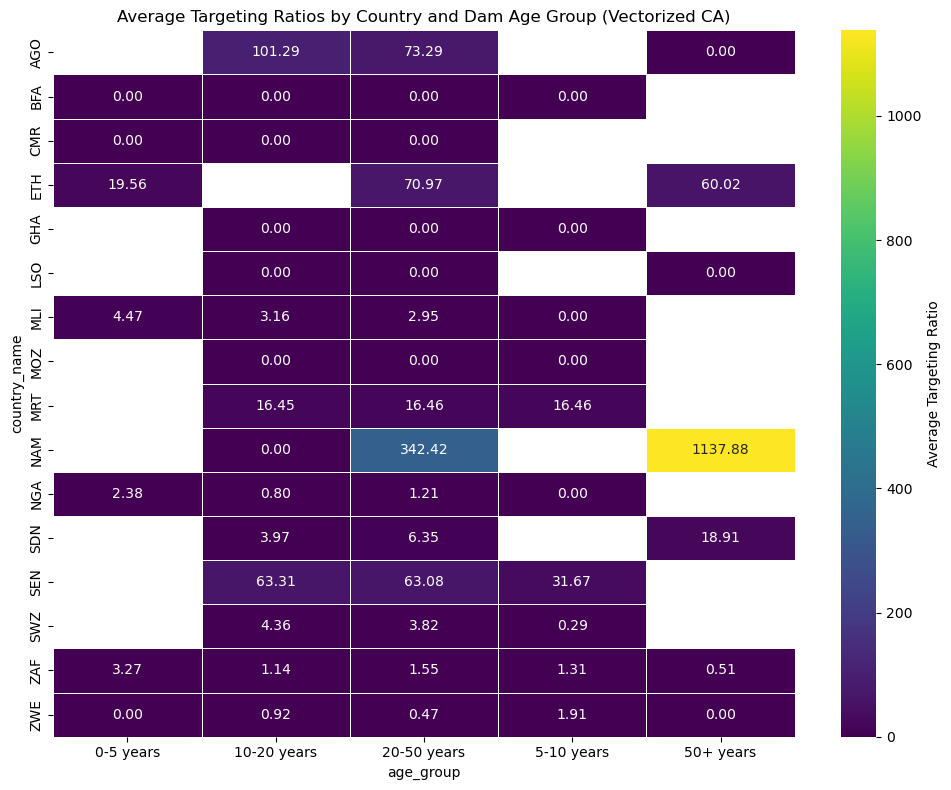

Calculating alternative metrics (Vectorized CA)...


Processing years: 100%|██████████| 4/4 [00:15<00:00,  3.90s/it]



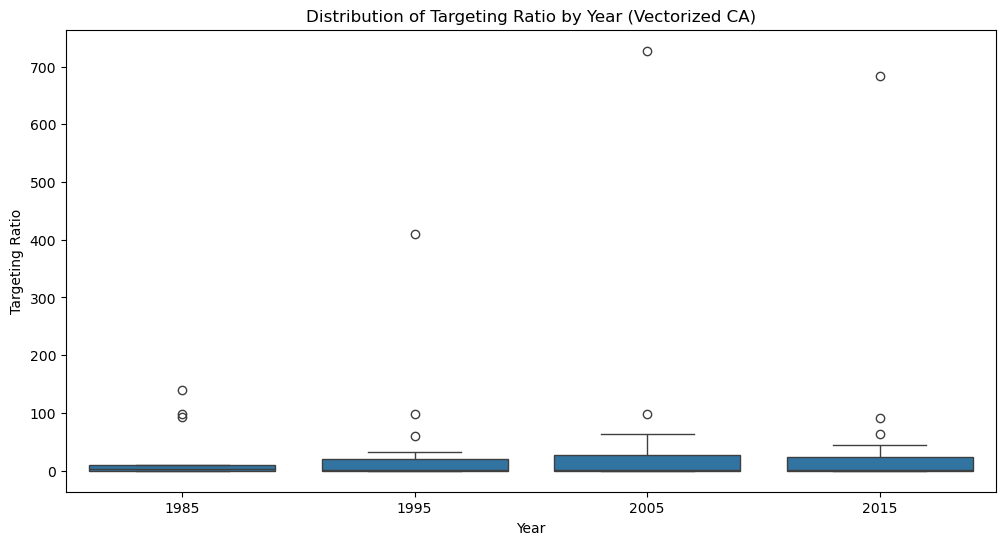

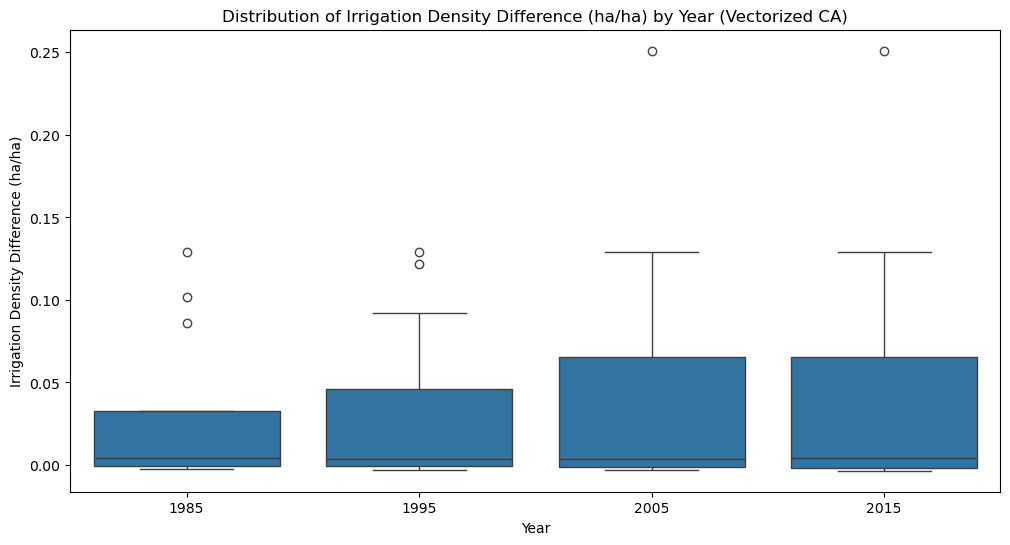

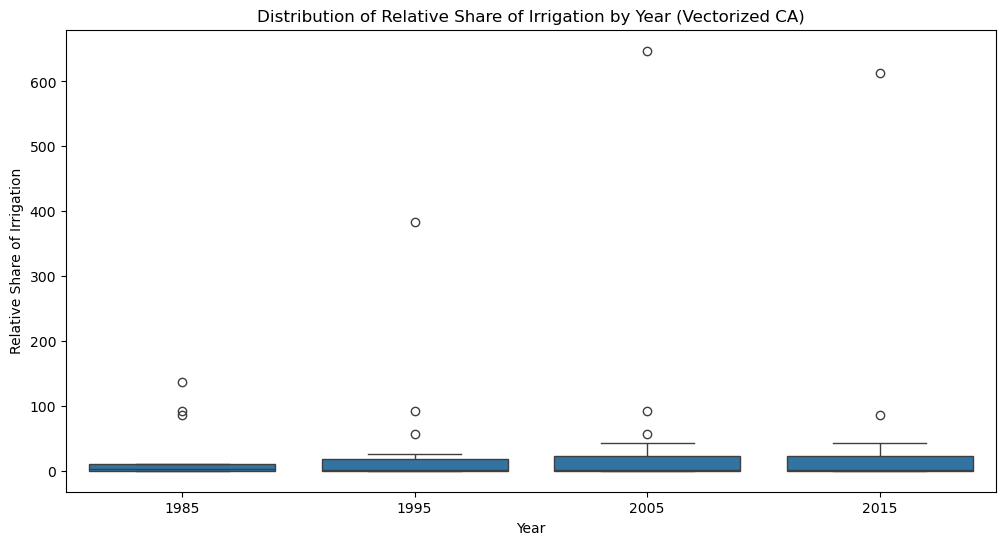

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


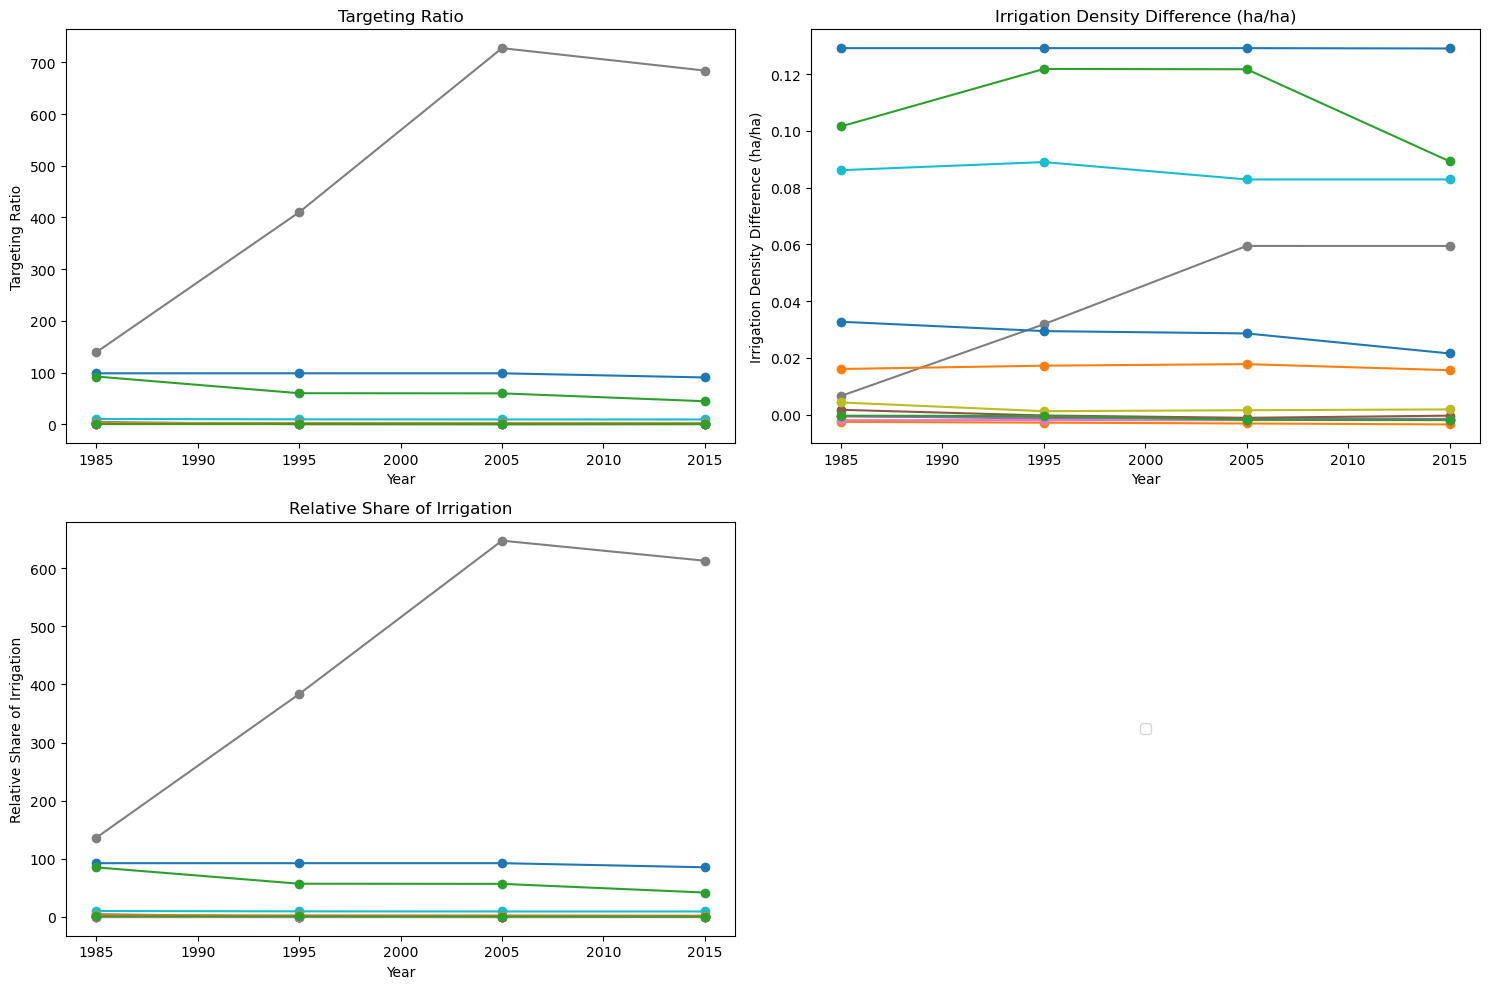

In [22]:
print("Running temporal analysis (Vectorized CA)...")
temporal_results_df_vectorized = calculate_temporal_targeting_ratios(
    analysis_years, dams_gdf, ca_gdf_vectorized_dissolved, ssa_arid_dissolved)
visualize_temporal_results(temporal_results_df_vectorized, output_dir_vectorized, title_suffix=" (Vectorized CA)")

print("Calculating alternative metrics (Vectorized CA)...")
alt_results_df_vectorized = calculate_alternative_metrics(
    analysis_years, dams_gdf, ca_gdf_vectorized_dissolved, ssa_arid_dissolved)
visualize_alternative_metrics(alt_results_df_vectorized, output_dir_vectorized, title_suffix=" (Vectorized CA)")

---

**You can now compare the results from both command area datasets and all metrics to assess the impact of delineation method on targeting ratios and irrigation patterns.**

### 4.3 Example Targeting Ratio Values by Country

Below are sample values of the main targeting ratio calculation for a selection of countries and years, for both the Initial and Vectorized Command Area Polygons. This table provides a direct look at the underlying numbers behind the visualizations.

In [37]:
# Display a summary table of targeting ratio values for a few countries and years
example_countries = ['EGY', 'ETH', 'NGA', 'ZAF', 'SDN']  # Egypt, Ethiopia, Nigeria, South Africa, Sudan
example_years = [1985, 1995, 2005, 2015]

# Initial CA
print('Initial Command Area Polygons:')
display_cols = ['year', 'ISO', 'country_name', 'irrigated_area_ca_ha', 'command_area_ha', 'country_aei_ha', 'country_land_area_ha', 'targeting_ratio_area']
example_df_initial = results_df_initial[
    results_df_initial['ISO'].isin(example_countries) & results_df_initial['year'].isin(example_years)
][display_cols].sort_values(['ISO', 'year'])
display(example_df_initial)

# Vectorized CA
print('Vectorized Command Area Polygons:')
example_df_vectorized = results_df_vectorized[
    results_df_vectorized['ISO'].isin(example_countries) & results_df_vectorized['year'].isin(example_years)
][display_cols].sort_values(['ISO', 'year'])
display(example_df_vectorized)

Initial Command Area Polygons:


,year,ISO,country_name,irrigated_area_ca_ha,command_area_ha,country_aei_ha,country_land_area_ha,targeting_ratio_area
2,1985,ETH,ETH,21298.480469,6.622417e+05,8.882218e+04,7.370717e+07,34.790923
16,1995,ETH,ETH,35527.000000,6.622417e+05,1.598430e+05,7.370717e+07,31.521377
32,2005,ETH,ETH,35505.960938,6.622417e+05,1.604471e+05,7.370717e+07,31.345069
48,2015,ETH,ETH,37501.074219,7.122931e+05,1.604471e+05,7.370717e+07,31.258113
8,1985,NGA,NGA,46807.007812,4.333095e+06,1.520270e+05,4.044303e+07,3.707158
23,1995,NGA,NGA,55884.039062,6.031338e+06,1.755033e+05,4.044303e+07,2.665502
39,2005,NGA,NGA,66173.718750,6.045282e+06,2.137365e+05,4.044303e+07,2.551657
55,2015,NGA,NGA,71127.609375,6.045282e+06,2.336227e+05,4.044303e+07,2.490642
9,1985,SDN,SDN,216375.078125,3.017156e+06,1.754356e+06,1.871256e+08,8.584836
24,1995,SDN,SDN,221737.140625,3.017156e+06,1.937356e+06,1.871256e+08,7.886665


Vectorized Command Area Polygons:


,year,ISO,country_name,irrigated_area_ca_ha,command_area_ha,country_aei_ha,country_land_area_ha,targeting_ratio_area
2,1985,ETH,ETH,7151.482910,6.965961e+04,8.882218e+04,7.370717e+07,92.565239
16,1995,ETH,ETH,8627.459961,6.965961e+04,1.598430e+05,7.370717e+07,60.312134
32,2005,ETH,ETH,8620.291992,6.965961e+04,1.604471e+05,7.370717e+07,60.019377
48,2015,ETH,ETH,10554.776367,1.156074e+05,1.604471e+05,7.370717e+07,44.824139
8,1985,NGA,NGA,175.471893,2.182394e+04,1.520270e+05,4.044303e+07,2.140250
23,1995,NGA,NGA,213.380402,3.847539e+04,1.755033e+05,4.044303e+07,1.278336
39,2005,NGA,NGA,264.435913,3.871505e+04,2.137365e+05,4.044303e+07,1.292788
55,2015,NGA,NGA,294.561584,3.871505e+04,2.336227e+05,4.044303e+07,1.317519
9,1985,SDN,SDN,57536.890625,6.042092e+05,1.754356e+06,1.871256e+08,10.467716
24,1995,SDN,SDN,59847.214844,6.042092e+05,1.937356e+06,1.871256e+08,9.840180


### 4.4 Four-Panel Map: Targeting Ratio by Country for Each Year

The figure below shows four side-by-side maps, one for each analysis year. Each country is colored according to its targeting ratio (Initial Command Area Polygons), allowing for direct visual comparison of spatial patterns and changes over time.

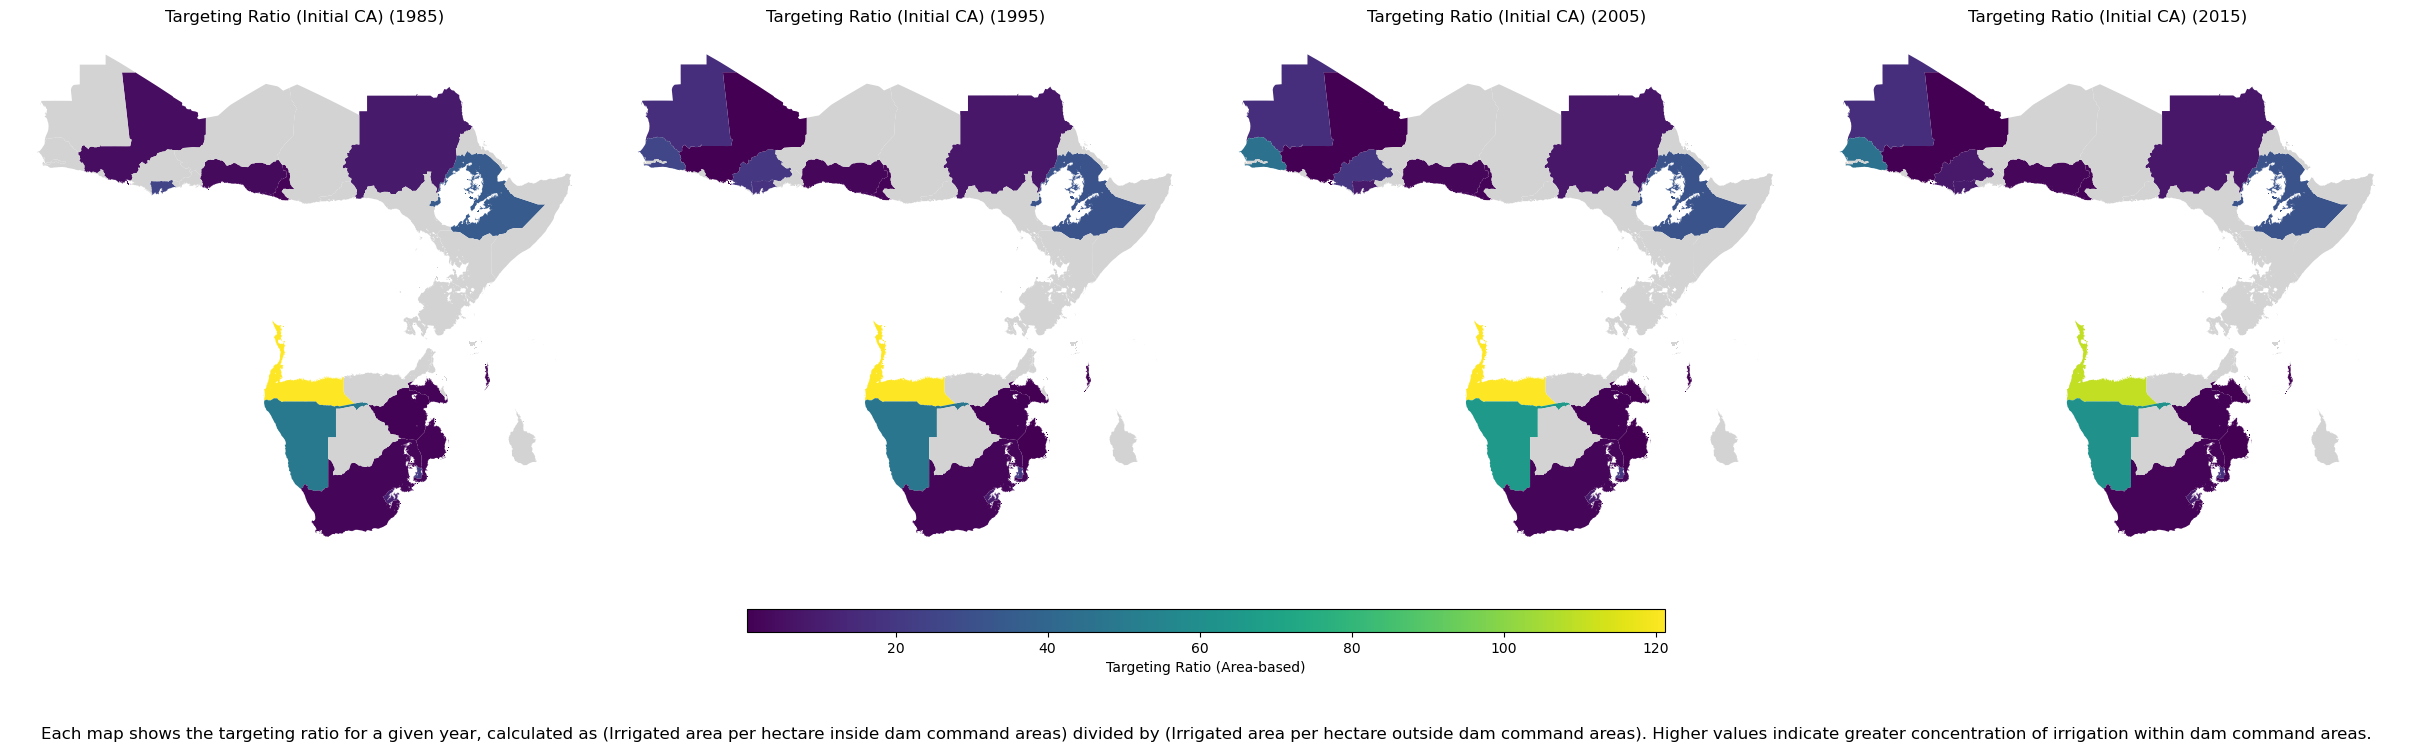

In [38]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl

def plot_four_panel_map(results_df, base_gdf, value_col, years, cmap='viridis', vmin=None, vmax=None, title_prefix="Targeting Ratio by Country"):
    fig, axes = plt.subplots(1, 4, figsize=(24, 7), constrained_layout=True)
    if vmin is None or vmax is None:
        vmin = results_df[value_col].min()
        vmax = results_df[value_col].max()
    for i, year in enumerate(years):
        ax = axes[i]
        year_df = results_df[results_df['year'] == year][['ISO', value_col]]
        merged = base_gdf.merge(year_df, on='ISO', how='left')
        merged.plot(column=value_col, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, legend=False, missing_kwds={"color": "lightgrey"})
        ax.set_title(f"{title_prefix} ({year})")
        ax.axis('off')
    # Add a single colorbar
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.04, pad=0.08, aspect=40)
    cbar.set_label('Targeting Ratio (Area-based)')
    plt.figtext(0.5, -0.08, "Each map shows the targeting ratio for a given year, calculated as (Irrigated area per hectare inside dam command areas) divided by (Irrigated area per hectare outside dam command areas). Higher values indicate greater concentration of irrigation within dam command areas.", wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

# Plot for Initial Command Area Polygons
plot_four_panel_map(
    results_df_initial,
    ssa_arid_dissolved,
    value_col='targeting_ratio_area',
    years=analysis_years,
    cmap='viridis',
    title_prefix="Targeting Ratio (Initial CA)"
)